In [3]:

from IPython.display import display, Markdown
import snakemd

import fitfile
from garmindb import ConfigManager, GarminConnectConfigManager
from garmindb.garmindb import GarminDb, Attributes, ActivitiesDb, Activities, StepsActivities, ActivityLaps, ActivityRecords
from idbutils.list_and_dict import list_not_none

def format_number(number, digits=0):
    """Format a number for display."""
    if number is not None:
        return round(number, digits)
    return '-'

gc_config = GarminConnectConfigManager()
db_params_dict = ConfigManager.get_db_params()


garmin_db = GarminDb(db_params_dict)
garmin_act_db = ActivitiesDb(db_params_dict)
measurement_system = Attributes.measurements_type(garmin_db)
unit_strings = fitfile.units.unit_strings[measurement_system]
distance_units = unit_strings[fitfile.units.UnitTypes.distance_long]

def __report_sport(sport_col, sport):
    records = Activities.row_count(garmin_act_db, sport_col, sport)
    if records > 0:
        sport_title = sport.title().replace('_', ' ')
        total_distance = Activities.get_col_sum_for_value(garmin_act_db, Activities.distance, sport_col, sport)
        if total_distance is None:
            total_distance = 0
            average_distance = 0
        else:
            average_distance = total_distance / records
        return [sport_title, records, format_number(total_distance, 1), format_number(average_distance, 1)]

doc = snakemd.new_doc()

doc.add_heading("Activities Report")
doc.add_paragraph("Analysis of all activities in the database.")

doc.add_table(
    ['Type', 'Count'],
    [
        ["Total activities", Activities.row_count(garmin_act_db)],
        ["Total Lap records", ActivityLaps.row_count(garmin_act_db)],
        ["Activity records", ActivityRecords.row_count(garmin_act_db)],
        ["Fitness activities", Activities.row_count(garmin_act_db, Activities.type, 'fitness')],
        ["Recreation activities", Activities.row_count(garmin_act_db, Activities.type, 'recreation')]
    ])

years = Activities.get_years(garmin_act_db)
years.sort()
doc.add_paragraph(f"Years with activities: {len(years)}: {years}")
sports = list_not_none(Activities.get_col_distinct(garmin_act_db, Activities.sport))
doc.add_paragraph(f"Sports: {', '.join(sports)}")
sub_sports = list_not_none(Activities.get_col_distinct(garmin_act_db, Activities.sub_sport))
doc.add_paragraph(f"SubSports: {', '.join(sub_sports)}")

sports_stats = []
for sport_name in [sport.name for sport in fitfile.Sport]:
    sport_stat = __report_sport(Activities.sport, sport_name)
    if sport_stat:
        sports_stats.append(sport_stat)
doc.add_heading("Sport Type Statistics", 3)
doc.add_table(['Sport', 'Total Activities', f'Total Distance ({distance_units})', f"Average Distance ({distance_units})"], sports_stats)

def __format_activity(activity):
    if activity:
        if activity.is_steps_activity():
            steps_activity = StepsActivities.get(garmin_act_db, activity.activity_id)
            return [activity.activity_id, activity.name, activity.type, activity.sport, format_number(activity.distance, 1), activity.elapsed_time, format_number(activity.avg_speed, 1), steps_activity.avg_pace, format_number(activity.calories)]
        return [activity.activity_id, activity.name, activity.type, activity.sport, format_number(activity.distance, 1), activity.elapsed_time, format_number(activity.avg_speed, 1), '', format_number(activity.calories)]
    return ['', '', '', '', '', '', '', '', '']

activities = Activities.get_latest(garmin_act_db, 10)
rows = [__format_activity(activity) for activity in activities]
doc.add_heading("Last Ten Activities", 3)
doc.add_table(['Id', 'Name', 'Type', 'Sport', f'Distance ({distance_units})', 'Elapsed Time', f'Speed ({unit_strings[fitfile.units.UnitTypes.speed]})', f'Pace ({unit_strings[fitfile.units.UnitTypes.pace]})', 'Calories'], rows)

rows = []
for display_activity in gc_config.display_activities():
    name = display_activity.activity_name().capitalize()
    rows.append([f'Latest {name}'] + __format_activity(Activities.get_latest_by_sport(garmin_act_db, display_activity)))
    rows.append([f'Fastest {name}'] + __format_activity(Activities.get_fastest_by_sport(garmin_act_db, display_activity)))
    rows.append([f'Slowest {name}'] + __format_activity(Activities.get_slowest_by_sport(garmin_act_db, display_activity)))
    rows.append([f'Longest {name}'] + __format_activity(Activities.get_longest_by_sport(garmin_act_db, display_activity)))

doc.add_heading("Interesting Activities", 3)
doc.add_table(['What', 'Id', 'Name', 'Type', 'Sport', f'Distance ({distance_units})', 'Elapsed Time', f'Speed ({unit_strings[fitfile.units.UnitTypes.speed]})', f'Pace ({unit_strings[fitfile.units.UnitTypes.pace]})', 'Calories'], rows)

doc.add_heading("Courses", 3)
courses = Activities.get_col_distinct(garmin_act_db, Activities.course_id)
doc.add_paragraph(str(courses))

display(Markdown(str(doc)))

# Activities Report

Analysis of all activities in the database.

| Type                  | Count  |
| --------------------- | ------ |
| Total activities      | 45     |
| Total Lap records     | 375    |
| Activity records      | 109018 |
| Fitness activities    | 0      |
| Recreation activities | 0      |

Years with activities: 2: [2023, 2024]

Sports: cycling, running, fitness_equipment, swimming

SubSports: road, generic, strength_training, lap_swimming

### Sport Type Statistics

| Sport             | Total Activities | Total Distance (kilometers) | Average Distance (kilometers) |
| ----------------- | ---------------- | --------------------------- | ----------------------------- |
| Running           | 4                | 38.9                        | 9.7                           |
| Cycling           | 38               | 2005.3                      | 52.8                          |
| Fitness Equipment | 1                | 0.0                         | 0.0                           |
| Swimming          | 2                | 3.1                         | 1.6                           |

### Last Ten Activities

| Id          | Name                            | Type          | Sport             | Distance (kilometers) | Elapsed Time    | Speed (kph) | Pace (per kilometers) | Calories |
| ----------- | ------------------------------- | ------------- | ----------------- | --------------------- | --------------- | ----------- | --------------------- | -------- |
| 13486398895 | Frederiksberg Bieganie          | uncategorized | running           | 13.5                  | 01:20:43.802000 | 10.1        | 00:05:57.781753       | 983      |
| 13470481040 | Pływanie w basenie              | uncategorized | swimming          | 1.6                   | 00:44:00.578000 | 2.9         |                       | 489      |
| 13454174371 | Frederiksberg - Run Intervals 1 | uncategorized | running           | 9.7                   | 00:51:35.471000 | 11.3        | 00:05:17.662008       | 736      |
| 13444468949 | 45 min Intervals1               | uncategorized | swimming          | 1.5                   | 00:46:20.858000 | 3.1         |                       | 367      |
| 13429141511 | Frederiksberg Bieganie          | uncategorized | running           | 7.7                   | 00:44:51.217000 | 10.3        | 00:05:51.123596       | 576      |
| 13359788245 | Strength                        | uncategorized | fitness_equipment | 0.0                   | 01:00:54.225000 | 0.0         |                       | 357      |
| 13328176025 | Gdynia Bieganie                 | uncategorized | running           | 8.0                   | 00:45:57.330000 | 11.1        | 00:05:25.520833       | 565      |
| 12036569364 | Gdynia Kolarstwo szosowe        | uncategorized | cycling           | 73.4                  | 03:07:46.643000 | 26.5        |                       | 2517     |
| 12022805012 | Żukowo Kolarstwo szosowe        | uncategorized | cycling           | 32.7                  | 01:09:29.064000 | 28.2        |                       | 1210     |
| 12007722208 | Żukowo Kolarstwo szosowe        | uncategorized | cycling           | 28.4                  | 01:15:08.313000 | 22.7        |                       | 897      |

### Interesting Activities

| What         | Id          | Name                            | Type          | Sport   | Distance (kilometers) | Elapsed Time    | Speed (kph) | Pace (per kilometers) | Calories |
| ------------ | ----------- | ------------------------------- | ------------- | ------- | --------------------- | --------------- | ----------- | --------------------- | -------- |
| Latest Walk  |             |                                 |               |         |                       |                 |             |                       |          |
| Fastest Walk |             |                                 |               |         |                       |                 |             |                       |          |
| Slowest Walk |             |                                 |               |         |                       |                 |             |                       |          |
| Longest Walk |             |                                 |               |         |                       |                 |             |                       |          |
| Latest Run   | 13486398895 | Frederiksberg Bieganie          | uncategorized | running | 13.5                  | 01:20:43.802000 | 10.1        | 00:05:57.781753       | 983      |
| Fastest Run  | 13454174371 | Frederiksberg - Run Intervals 1 | uncategorized | running | 9.7                   | 00:51:35.471000 | 11.3        | 00:05:17.662008       | 736      |
| Slowest Run  | 13486398895 | Frederiksberg Bieganie          | uncategorized | running | 13.5                  | 01:20:43.802000 | 10.1        | 00:05:57.781753       | 983      |
| Longest Run  | 13486398895 | Frederiksberg Bieganie          | uncategorized | running | 13.5                  | 01:20:43.802000 | 10.1        | 00:05:57.781753       | 983      |
| Latest Ride  | 12036569364 | Gdynia Kolarstwo szosowe        | uncategorized | cycling | 73.4                  | 03:07:46.643000 | 26.5        |                       | 2517     |
| Fastest Ride | 11358048411 | Warszawa Kolarstwo szosowe      | uncategorized | cycling | 40.6                  | 01:11:51.510000 | 33.9        |                       | 1570     |
| Slowest Ride | 11087887215 | Kolarstwo szosowe               | uncategorized | cycling | 0.0                   | 00:00:01.552000 | 0.0         |                       | 0        |
| Longest Ride | 11567253794 | Mikołajki Kolarstwo szosowe     | uncategorized | cycling | 158.8                 | 11:06:16.843000 | 16.2        |                       | 4300     |

### Courses

[None, 159913385, 171610222, 164362571, 172829084, 143918720, 165824232, 158025737, 169975762, 157136955, 172636193, 176690917, 151372641, 169894605, 157170115, 163746739]

In [4]:
import datetime
from IPython.display import display, Markdown
import snakemd

from garmindb import ConfigManager
from garmindb.garmindb import GarminSummaryDb, DaysSummary

from graphs import Graph


def __render_day(garmin_sum_db, graph, date):
    day = DaysSummary.get_day(garmin_sum_db, date)
    if day:
        doc = snakemd.new_doc()
        doc.add_heading(f"Summary of {date}")
        doc.add_table(['Weight', 'Resting HR', 'Max HR', 'Waking Avg RR', 'Steps', 'Floors', 'Intensity Mins', 'Calories', 'Sleep', 'REM Sleep', 'Stress'],
            [
                [format_number(day.weight_avg), day.rhr_avg, day.hr_max, day.rr_waking_avg, day.steps, format_number(day.floors, 1),
                 day.intensity_time, day.calories_avg, day.sleep_avg, day.rem_sleep_avg, day.stress_avg]
            ]
        )
        display(Markdown(str(doc)))
    graph.graph_date(date)


db_params_dict = ConfigManager.get_db_params()
garmin_sum_db = GarminSummaryDb(db_params_dict)

graph = Graph()

# Summary of 2024-01-12

| Weight | Resting HR | Max HR | Waking Avg RR | Steps | Floors | Intensity Mins | Calories | Sleep    | REM Sleep | Stress |
| ------ | ---------- | ------ | ------------- | ----- | ------ | -------------- | -------- | -------- | --------- | ------ |
| -      | 56.0       | 159.0  | 13.0          | 13564 | 9.0    | 02:30:00       | 3274     | 08:35:00 | 02:02:00  | 22     |

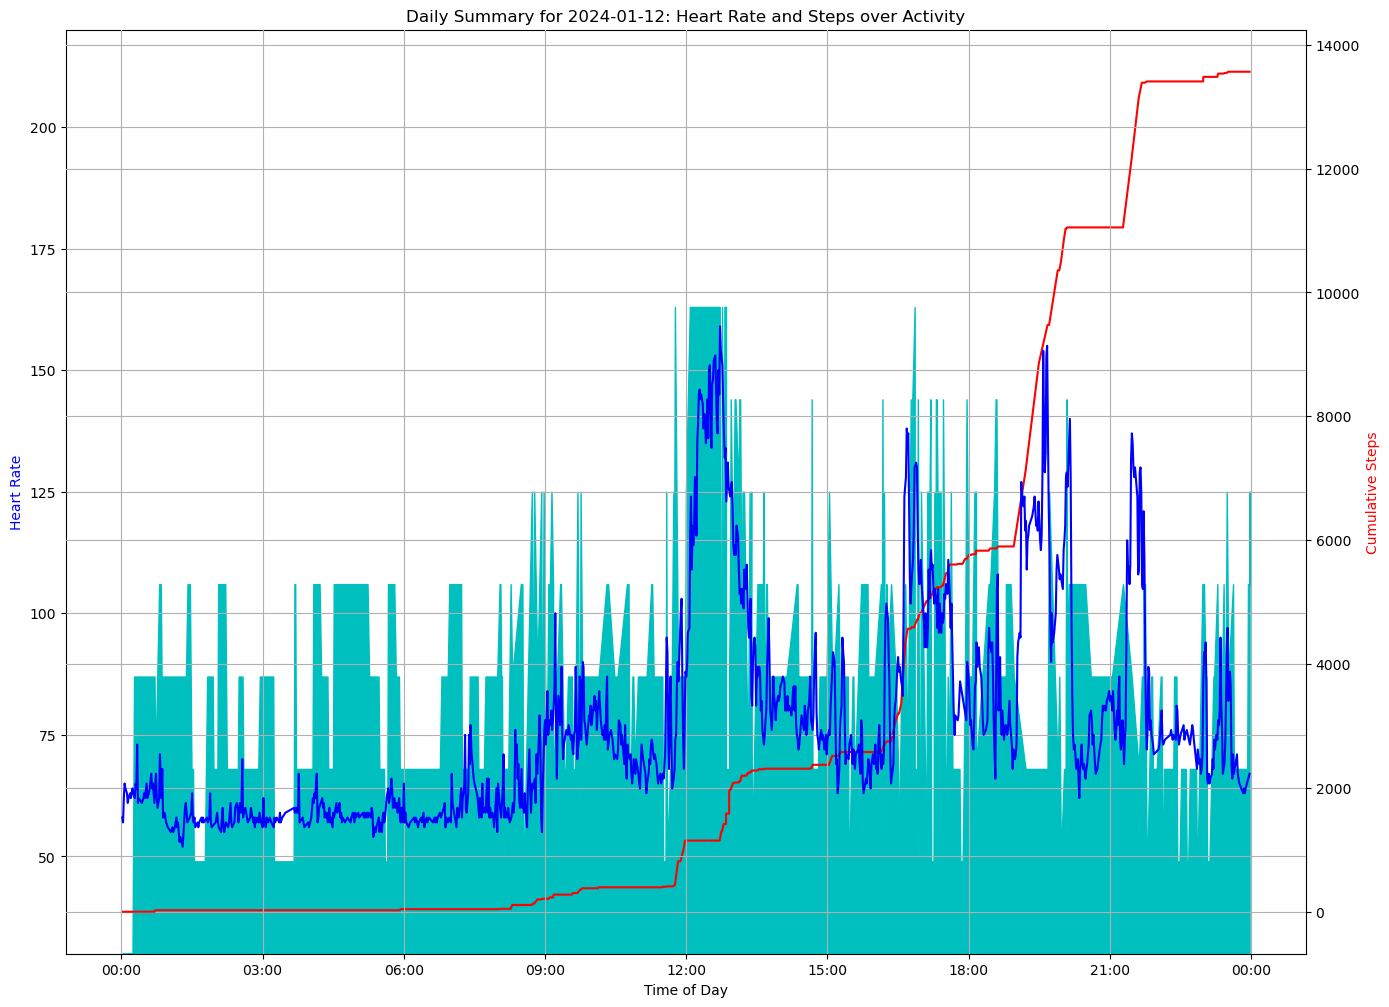

In [5]:
__render_day(garmin_sum_db, graph, datetime.date.today() - datetime.timedelta(days = 1))